<a href="https://colab.research.google.com/github/scaairesearch/da_demo/blob/main/da_mnist_demo_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation Demonstration
- get data (v1)
- create model architecture (v1)
- train baseline and non-da (v2)
- save baseline model (v3)
- train and test DANN(v4)
- save DANN (v4)
- train and test DANN EWC
- save DANN EWC
- infer model from the saved model (v3 - baseline)
- grad cam on correctly classified and misclassified images
- get mis classified images (updated -v5, v4)
- plot misclassified images (updated -v5, v4)
- storing misclassified images (v6)
- gradio app

# Objective / Target
**Objective / Target**
* Increase accuracy by increasing capacity
* Play with LR

**Results**

* Parameters: 7,900
* Best Train Accuracy: 98.91
* Best Test Accuracy: 99.31

**Analysis**

* Not Able to hit the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 8K
* Adding params near output helped much, so did removing input

**Next Steps**

* Play with large LR


# Importing Libraries

In [ ]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates
# from torch.utils.data import dataset # for MNISTM dataset
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy
import time


In [ ]:
str(time.strftime("%d_%m"))

'04_07'

## Seed and Cuda

In [ ]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

 Cuda Status : False
cpu


## Constants

In [ ]:
img_size = 28 # for mnist
cpu_batch_size = 64
cuda_batch_size = 128
EPOCHS = 1 # 15 if cuda else 2

target_drive_path = '/content/gdrive/MyDrive/mnist_m/dataset/mnist_m.tar.gz'
model_drive_path = '/content/gdrive/MyDrive/da_demo/cv/models'

data_base_path = '/content/data'
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join(data_base_path, source_dataset_name)
target_image_root = os.path.join(data_base_path, target_dataset_name)
model_root = 'models'
# cuda = True
# cudnn.benchmark = True
lr = 1e-3
# batch_size = 128
# image_size = 28
# n_epoch = 100

# Source Data

## Data Transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train / Test Split

In [ ]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15716757.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 576438.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4469391.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3574208.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Data Loader

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=cuda_batch_size, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

## Checking Dataloader

In [ ]:
# next(iter(train_loader))

torch.Size([64, 1, 28, 28]) torch.Size([64])
Label = 2


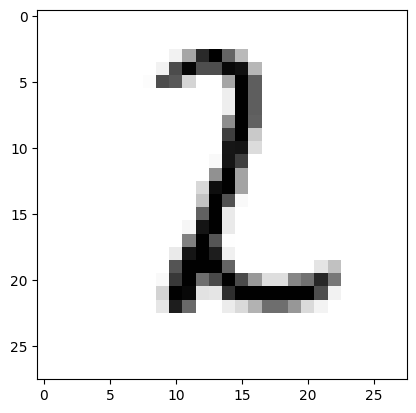

In [ ]:
images, labels  = next(iter(train_loader))
print(images.shape, labels.shape)
# printing random image and seeing
random_idx = random.randint(0,len(images))
plt.imshow(images[random_idx].numpy().squeeze(), cmap='gray_r')
print(f'Label = {labels[random_idx].item()}' )

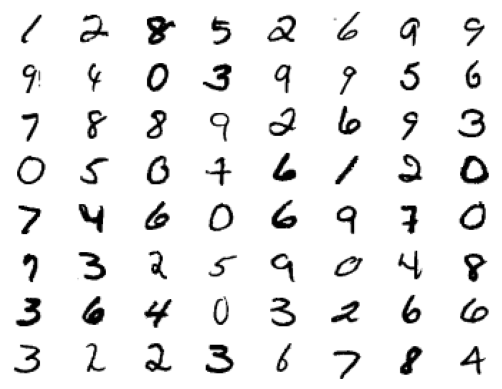

In [ ]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Target Data

## Data Transforms

In [ ]:
# Train Phase transformations
target_train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test Phase transformations
target_test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

## Dataset Class

In [ ]:
class MNISTM(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels, img_paths

    def __len__(self):
        return self.n_data

## Dataset

In [ ]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


## Extracting Dataset - one time

In [ ]:
import tarfile
import os
from pathlib import Path

if os.path.exists(target_drive_path):
    with tarfile.open(target_drive_path, 'r:gz') as tar:
      tar.extractall(path=data_base_path)
else:
    print(f"The directory {target_drive_path} does not exist.")

In [ ]:
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
train_root = os.path.join(target_image_root, 'mnist_m_train')
test_list = os.path.join(target_image_root, 'mnist_m_test_labels.txt')
test_root = os.path.join(target_image_root, 'mnist_m_test')

dataset_target_train = MNISTM(data_root = train_root,
                                 data_list = train_list,
                                 transform = target_train_transforms,
                                 )
dataset_target_test = MNISTM(data_root = test_root,
                                      data_list = test_list,
                                      transform = target_test_transforms,
                                      )

## Dataloader

In [ ]:

dataloader_target_train = torch.utils.data.DataLoader(
    dataset=dataset_target_train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

dataloader_target_test = torch.utils.data.DataLoader(
    dataset = dataset_target_test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

### Checking Dataloader

torch.Size([64, 3, 28, 28]) torch.Size([64])
Label = 7 
Name = 00016272.png


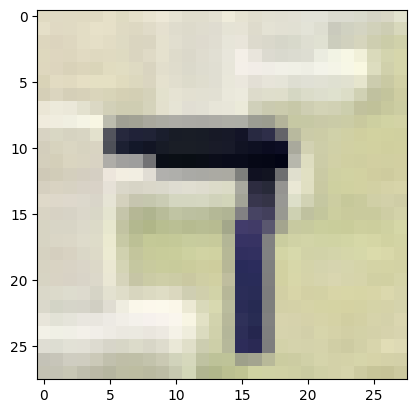

In [ ]:
images, labels,img_names  = next(iter(dataloader_target_train))
print(images.shape, labels.shape)
# printing random image and seeing
random_idx = random.randint(0,len(images))
random_img = images[random_idx].permute(1,2,0).numpy()
plt.imshow((random_img*0.5)+0.5)
print(f'Label = {labels[random_idx].item()} \nName = {img_names[random_idx]}' )

# Model

In [ ]:
# class Network(nn.Module):
#   def __init__(self):
#     super(Network,self).__init__() # extending super class method

#     drop_out_value = 0.1

#     # Input Block
#     self.convblock1 = nn.Sequential(
#         nn.Conv2d(3,16,3 , bias= False ), # In- 3x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 2
#     self.convblock2 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 3
#     self.convblock3 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Transition Block 1 (this also includes a conv block)
#     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2


#     # Conv Block 4
#     self.convblock4 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 5
#     self.convblock5 = nn.Sequential(
#         nn.Conv2d(16,32,3, bias= False ), # In- 16x9x9, Out- 32x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Output Block
#     self.convblock6 = nn.Sequential(
#         nn.Conv2d(32,64,1, bias= False ), # In- 32x7x7, Out- 64x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#     )

#     self.gap = nn.AvgPool2d(7) # In- 64x7x7, Out- 64x1x1, RF- 16x16, Jump_in -2, Jump_out -2

#     self.feature = nn.Sequential(self.convblock1,
#                                  self.convblock2,
#                                  self.convblock3,
#                                  self.pool1,
#                                  self.convblock4,
#                                  self.convblock5,
#                                  self.convblock6,
#                                  self.gap
#                                 )


#   def forward(self,x):
#     x = self.feature(x)

#     # x = self.convblock1(x)
#     # x = self.convblock2(x)
#     # x = self.convblock3(x)

#     # x = self.pool1(x)
#     # # x = self.convblock4(x)
#     # x = self.convblock5(x)
#     # x = self.convblock6(x)

#     # x = self.convblock7(x)

#     # x = self.gap(x)

#     # Flattening
#     x = x.view(-1,64)
#     return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class Network(nn.Module):
    def __init__(self, num_classes = 10):
        super(Network, self).__init__()  # Initialize the parent class

        drop_out_value = 0.1

        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor  = nn.Sequential(
            # Input Block
            nn.Conv2d(3, 16, 3, bias=False),  # In: 3x28x28, Out: 16x26x26, RF: 3x3, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 2
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x26x26, Out: 16x24x24, RF: 5x5, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 3
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x24x24, Out: 16x22x22, RF: 7x7, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Transition Block 1
            nn.MaxPool2d(kernel_size=2, stride=2),  # In: 16x22x22, Out: 16x11x11, RF: 8x8, Stride: 2

            # Conv Block 4
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x11x11, Out: 16x9x9, RF: 12x12, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 5
            nn.Conv2d(16, 32, 3, bias=False),  # In: 16x9x9, Out: 32x7x7, RF: 16x16, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(drop_out_value),

            # Output Block
            nn.Conv2d(32, 64, 1, bias=False),  # In: 32x7x7, Out: 64x7x7, RF: 16x16, Stride: 1

            # Global Average Pooling
            nn.AvgPool2d(7)  # In: 64x7x7, Out: 64x1x1, RF: 16x16, Stride: 7
        )

        #---------------------Class Classifier Network------------------------#
        self.class_classifier = nn.Sequential(nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(64,50),
                                        nn.BatchNorm1d(50), # added batch norm to improve accuracy
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(50,num_classes))

        #---------------------Label Classifier Network------------------------#
        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(64,50),
                                        nn.BatchNorm1d(50), # added batch norm to improve accuracy
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(50,2))
    def forward(self, input_data, alpha = 1.0):
      if input_data.data.shape[1] == 1:
        input_data = input_data.expand(input_data.data.shape[0], 3, img_size, img_size)

      input_data = self.feature_extractor(input_data)

      features = input_data.view(input_data.size(0), -1)  # Flatten the output for fully connected layer

      reverse_features = GradientReversalFn.apply(features, alpha)
      class_output = self.class_classifier(features)
      domain_output = self.domain_classifier(reverse_features)

      return class_output, domain_output, features

# Create an instance of the network and print it
model = Network()
print(model)


Network(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (14): ReLU()
    (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.1, inplace=False)
    (1

## Model Params

Model moved to device

In [ ]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(3, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             432
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-

# Testing and Performance

## UTIL Test Function

In [ ]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print("prediction shape", prediction.argmax(dim=1).shape)
    # print("labels shape ", labels.shape)
    return prediction.argmax(dim=1).eq(labels).sum().item()
    # return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [ ]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    pbar = tqdm(data_loader) # putting the dataloader in progress bar


    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(pbar):
        # for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    pbar.set_description(desc= f'Test / Val: Average loss={test_loss} Accuracy={correct}/{len(data_loader.dataset)}({100*correct/len(data_loader.dataset):0.2f}%)')

    return correct, test_loss

Checking accuracy before training

In [ ]:
correct, test_loss = test_model_local(model = model,
                                      device = device,
                                      data_loader = train_loader)
correct, test_loss

100%|██████████| 938/938 [00:42<00:00, 22.32it/s]


(6742, 0.03601807407538096)

## UTIL Performance Metric

In [ ]:
#TODO: Move to Utils

# labels_map={0:0,
#             1:1,
#             2:2,
#             3:3,
#             4:4,
#             5:"Surprise",
#             6:"Neutral"}
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd


def performance_metric(model,
                       device,
                       data_loader):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images)) # forward pass, output = {class}
          true_labels.extend(labels.cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())

    # true_labels = [labels_map[int_label] for int_label in true_labels]
    # predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    # class_names = list(labels_map.values())
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    # print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report

## UTIL Misclassified Images

In [ ]:
# def get_misclassified_images_list_v2(model,
#                                   device,
#                                   test_loader,
#                                   num_image = None,
#                                   class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']):
#   '''
#   returns list of misclassified images, it does not display the images
#   '''
#   model = model.to(device)
#   model.eval() # setting the model in evaluation mode
#   wrong_images = []
#   wrong_label = []
#   correct_label = []





In [ ]:
def get_misclassified_images_list(model,
                                  device,
                                  test_loader,
                                  num_image = 10,
                                  class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']):
  '''
  returns list of misclassified images, it does not display the images
  '''
  model = model.to(device)
  model.eval() # setting the model in evaluation mode

  if num_image is None or num_image == 'all': num_image = len(test_loader.dataset)

  list_misclassified_images, labels_list, preds_list = [],[],[] # initialize
  with torch.no_grad():
    for epoch in range (1):
      for batch in test_loader:
        images, labels = batch[0].to(device),batch[1].to(device) #sending data to CPU or GPU as per device
        outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
        preds = outputs[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        output_match_list = preds.eq(labels.view_as(preds)).squeeze().tolist()

        labels_list = labels.squeeze().tolist()
        preds_list = preds.squeeze().tolist()

        for index, bool_value in enumerate(output_match_list):
          if not bool_value: # looking for misclassified
            if len(batch) == 3:
              list_misclassified_images.append((batch[0][index],batch[1][index],preds[index],batch[2][index]))
            else:
              list_misclassified_images.append((batch[0][index],batch[1][index],preds[index]))
            if len(list_misclassified_images) == num_image: break
        if len(list_misclassified_images) == num_image: break
  return list_misclassified_images


## UTIL Plot Misclassified Images

In [ ]:
import numpy as np

def unnormalize(image_tensor, mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5]):
    """
    Unnormalize a tensor image.
    Args:
        image_tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        mean (list): Mean values for each channel.
        std (list): Standard deviation values for each channel.
    Returns:
        np.ndarray: Unnormalized image as a numpy array.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    image = image_tensor.permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C) and convert to numpy array
    image = np.clip(image, 0, 1)  # clip to [0, 1]
    return image

In [ ]:
def plot_misclassified_images (list_misclassified_images,
                               num_image = 10,
                               mean = [0.5,0.5,0.5],
                               std = [0.5,0.5,0.5],
                               class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']):
  '''
  Plotting misclassified images function
  '''
  if len(list_misclassified_images) == 0: return

  if num_image > len(list_misclassified_images) or num_image is None:
    num_image = len(list_misclassified_images)


  bool_image_name_present = False
  if len(list_misclassified_images[0]) > 3:
    bool_image_name_present = True

  figure = plt.figure(figsize = (10,5))
  for index in range(1, num_image + 1):
      plt.subplot(2, int(num_image/2), index)
      plt.axis('off')
      image = unnormalize(list_misclassified_images[index-1][0], mean, std)
      # image = np.transpose(list_misclassified_images[index-1][0], (1, 2, 0))
      # plt.imshow(list_misclassified_images[index-1][0].cpu().numpy().squeeze(), cmap='gray_r')
      # plt.imshow(image, cmap='gray_r') # gray scale
      plt.imshow(image) # coloured
      GT_label = class_names[list_misclassified_images[index-1][1].item()]
      Pred_Label = class_names[list_misclassified_images[index-1][2].item()]
      if bool_image_name_present:
        file_name = list_misclassified_images[index-1][3].split(os.path.sep)[-1]
        plt.title(f'{file_name}\nGT: {GT_label} \nPred: {Pred_Label}',fontdict={'fontsize': 6})
      else:
        plt.title(f'GT: {GT_label} \nPred: {Pred_Label} ')
  plt.show()


In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model,
                                                                                                   device= device,
                                                                                                   data_loader = train_loader, # source val loader
                                                                                                   )

Accuracy: 0.11236666666666667
Precision: 0.01262626777777778
Confusion Matrix:
   0     1  2  3  4  5  6  7  8  9
0  0  5923  0  0  0  0  0  0  0  0
1  0  6742  0  0  0  0  0  0  0  0
2  0  5958  0  0  0  0  0  0  0  0
3  0  6131  0  0  0  0  0  0  0  0
4  0  5842  0  0  0  0  0  0  0  0
5  0  5421  0  0  0  0  0  0  0  0
6  0  5918  0  0  0  0  0  0  0  0
7  0  6265  0  0  0  0  0  0  0  0
8  0  5851  0  0  0  0  0  0  0  0
9  0  5949  0  0  0  0  0  0  0  0
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5923
           1       0.11      1.00      0.20      6742
           2       0.00      0.00      0.00      5958
           3       0.00      0.00      0.00      6131
           4       0.00      0.00      0.00      5842
           5       0.00      0.00      0.00      5421
           6       0.00      0.00      0.00      5918
           7       0.00      0.00      0.00      6265
           8       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

# Non DANN

## Training Function with LR Scheduler

In [ ]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


### Execution of Training Function

In [ ]:

model = Network().to(device=device)
best_model = Network().to(device=device)

#learning rate
lr =  0.4

# Epochs
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 1
scheduler_factor = 0.1
scheduler_threshold = 0.0002

# # Early stopping params
# early_stop_patience = 15 #runconfig.early_stop_patience
# early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = nn.CrossEntropyLoss().to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = test_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    # if early_stopping_difference(list_val_correct,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    # if early_stopping_difference(list_best_val_correct,
    #                              patience = 2*early_stop_patience,
    #                              difference= 0):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break



    # ## showing misclassification images after every 10 epochs
    # if epoch % 10 == 0:
    #   list_misclassified_images = get_misclassified_images_list(model= model,
    #                                                             device = device,
    #                                                             test_loader = data_loader['source']['val'],
    #                                                             num_image = 10)
    #   plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')




dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                      #  'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


------ Training started for Non DANN Model ---- 
starting LR : 0.4
EPOCH: 1  of  1
epoch = 1...in training function


Loss=0.028497328981757164 Accuracy=54805/60000(91.34%) Epoch Avg loss=0.00448121 LR=0.400000: 100%|██████████| 938/938 [01:44<00:00,  8.98it/s]
100%|██████████| 157/157 [00:06<00:00, 23.81it/s]

last correct =9830 | best correct = 0
Updated the best model with correct: 9830

Best model loaded


## Performance on source validation dataset

> Add blockquote



In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = test_loader ,
                                                                                                   )

Accuracy: 0.983
Precision: 0.983107670243715
Confusion Matrix:
     0     1     2    3    4    5    6     7    8    9
0  972     1     2    0    0    0    3     2    0    0
1    0  1124     4    0    0    1    5     1    0    0
2    2     0  1017    0    2    0    6     3    2    0
3    0     0     4  990    0    5    0     7    4    0
4    0     0     0    0  971    0    7     2    0    2
5    0     0     1    5    0  872    4     2    6    2
6    9     2     0    0    1    1  943     0    2    0
7    0     3     4    1    0    0    0  1018    0    2
8    3     0     2    0    4    1    1     3  958    2
9    8     0     1    0   17    2    2     7    7  965
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99     

## Performance on target validation dataset





In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = dataloader_target_test ,
                                                                                                   )

NameError: name 'best_model' is not defined

## Saving NON DANN MODEL

In [ ]:
dir_suffix = str(time.strftime("%d_%m"))

SPECIFIC_MODEL_DIR = Path(os.path.join(model_drive_path, dir_suffix))
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')


Directory /content/gdrive/MyDrive/da_demo/cv/models/26_06 already exists.


In [ ]:
model_name = f'non_dann_{dir_suffix}.pt'
print("\nDO VERIFY THE MODEL NAME BEFORE MOVING AHEAD: ", model_name)


DO VERIFY THE MODEL NAME BEFORE MOVING AHEAD:  non_dann_26_06.pt


In [ ]:
torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

# Loading Non DANN for DANN, DANN EWC

In [ ]:
# dann_model_name = model_name # f'non_dann_{str(time.strftime("%d_%m"))}.pt'

dann_model_name = 'non_dann_26_06.pt'
dir_suffix = '26_06' # str(time.strftime("%d_%m"))

SPECIFIC_MODEL_DIR = Path(os.path.join(model_drive_path, dir_suffix))
dann_model_path = Path(SPECIFIC_MODEL_DIR,dann_model_name)
print("\n**** model name that would be used for loading: ", dann_model_path)


**** model name that would be used for loading:  /content/gdrive/MyDrive/da_demo/cv/models/26_06/non_dann_26_06.pt


In [ ]:
if not device:
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


### DANN loaded with Non DANN weights

In [ ]:
model_dann = Network().to(device)
model_dann.load_state_dict(torch.load(dann_model_path,map_location = torch.device(device)))

<All keys matched successfully>

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model_dann,
                                                                                                   device= device,
                                                                                                   data_loader = dataloader_target_test ,
                                                                                                   )

Accuracy: 0.33985112765248304
Precision: 0.7484327284691743
Confusion Matrix:
     0    1    2    3    4    5    6    7    8    9
0  290    0    0    0    8   37    7    0  532    4
1   27  306    2    0   20    1   15    6  634    5
2    3    0  252    0   21   51    7    5  591    3
3    4    1   22  179    3   29    0   11  658    1
4    8    1    0    1  303   29    5    2  528   13
5    3    1    1    1    3  199    2    1  594    2
6   36    0    4    0   40   20  233    0  519    4
7    1    8    5    4   17   12    0  268  592    7
8    8    0    0    0    3   10    1    1  857    0
9    6    2    2    0   51   13    1    3  669  172
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.33      0.46       878
           1       0.96      0.30      0.46      1016
           2       0.88      0.27      0.41       933
           3       0.97      0.20      0.33       908
           4       0.65      0.34      0.45       890
  

### DANN EWC loaded with Non DANN weights

In [ ]:
model_dann_ewc = Network().to(device)
model_dann_ewc.load_state_dict(torch.load(dann_model_path,map_location = torch.device(device)))

<All keys matched successfully>

# DANN Model

## DANN Training function

In [ ]:
def train_dann(model,
                device,
                source_train_loader, source_val_loader,
                target_train_loader, target_val_loader,
                optimizer,
                n_epochs, # total number of epochs (different from individual epoch)
                class_loss_function = nn.CrossEntropyLoss(),
                domain_loss_function = nn.BCEWithLogitsLoss(),
                scheduler = None,
                early_stop_patience = None,
                early_stop_difference = None
                ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            # alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss

            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain)
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 100 batches
            if (batch_idx % 100 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        # #TODO: Early Stopping
        # if early_stop_patience and early_stop_difference: # early stopping required
        #   if early_stopping_difference(list_val_correct,
        #                                patience = early_stop_patience,
        #                                difference= early_stop_difference):
        #     print (f'-------Early Stopping at epoch {epoch_idx+1}---')
        #     epoch_converge = epoch_idx+1
        #     break # break from epoch loop

        # if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
        #   if early_stopping_difference(val_losses,
        #                                patience = 2*early_stop_patience,
        #                                difference= 0):
        #     print (f'-------Early Stopping at epoch {epoch_idx+1}---')
        #     epoch_converge = epoch_idx+1
        #     break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        # if epoch_idx % 10 == 0:
        #   list_misclassified_images = get_misclassified_images_list(model= model,
        #                                                             device = device,
        #                                                             test_loader = source_val_loader,
        #                                                             num_image = 10)
        #   plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    # correct, test_loss_source = test_model_local(model= model,
    #                         device= device,
    #                         data_loader = source_val_loader, # source val loader
    #                         class_loss_function = class_loss_function)

    # correct, test_loss_target = test_model_local(model= model,
    #                         device= device,
    #                         data_loader = target_val_loader, # target val loader
    #                         class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        # 'test_loss_source' : test_loss_source,
                        # 'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [ ]:

#learning rate
lr_dann =  0.04 # slow rate as the weights are already optimized

# Epochs
print("EPOCHS", EPOCHS)
n_epochs = EPOCHS

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 1
scheduler_factor = 0.1
scheduler_threshold = 0.0002


# optimizer
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)


EPOCHS 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = train_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = train_loader,
                                                    source_val_loader = test_loader,
                                                    target_train_loader = dataloader_target_train,
                                                    target_val_loader = dataloader_target_test,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = nn.CrossEntropyLoss().to(device=device),
                                                    domain_loss_function = nn.BCEWithLogitsLoss(),
                                                    scheduler = scheduler,
                                                    early_stop_patience = None,
                                                    early_stop_difference = None
                                                    )

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch[1/1] Step[1/922]: loss_total=1.4887 / domain_loss_target=0.8108 / domain_loss_source=0.6051 / task_loss=0.0729 / domain_loss=0.6780 / alpha=0.00 / lr=0.040000
Epoch[1/1] Step[101/922]: loss_total=1.3433 / domain_loss_target=0.6512 / domain_loss_source=0.6283 / task_loss=0.0638 / domain_loss=0.6920 / alpha=0.49 / lr=0.040000
Epoch[1/1] Step[201/922]: loss_total=1.1947 / domain_loss_target=0.5341 / domain_loss_source=0.5569 / task_loss=0.1037 / domain_loss=0.6606 / alpha=0.79 / lr=0.040000
Epoch[1/1] Step[301/922]: loss_total=1.1593 / domain_loss_target=0.5584 / domain_loss_source=0.5874 / task_loss=0.0135 / domain_loss=0.6009 / alpha=0.93 / lr=0.040000
Epoch[1/1] Step[401/922]: loss_total=1.4260 / domain_loss_target=0.5630 / domain_loss_source=0.6612 / task_loss=0.2018 / domain_loss=0.8630 / alpha=0.97 / lr=0.040000
Epoch[1/1] Step[501/922]: loss_total=1.4372 / domain_loss_target=

100%|██████████| 157/157 [00:07<00:00, 20.29it/s]

last correct =9709 | best correct = 0
Updated the best model with correct: 9709

Best model loaded
alpha list 
 [0.0, 0.00542294033168389, 0.01084556171403217, 0.01626754527274077, 0.021688572283530272, 0.027108324247066662, 0.03252648296376526, 0.037942730608450104, 0.04335674980482218, 0.048768223699706015, 0.05417683603703494, 0.059582271231539474, 0.0649842144421009, 0.07038235164473616, 0.07577636970517654, 0.0811659564510061, 0.08655080074332333, 0.09193059254789282, 0.09730502300575128, 0.10267378450323661, 0.10803657074140349, 0.1133930768047946, 0.1187429992295368, 0.12408603607072655, 0.1294218869690773, 0.134750253216797, 0.14007083782266516, 0.1453833455762812, 0.1506874831114573, 0.15598295896872316, 0.1612694836569204, 0.1665467697138594, 0.17181453176601091, 0.17707248658720798, 0.18232035315633843, 0.18755785271399827, 0.19278470881808896, 0.1980006473983329, 0.20320539680969185, 0.20839868788466065, 0.2135802539844267, 0.2187498310488678, 0.22390715764537839, 0.2290519

## Performance on source validation dataset


In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = test_loader ,
                                                                                                   )

Accuracy: 0.9709
Precision: 0.9715403511428155
Confusion Matrix:
     0     1     2    3    4    5    6     7    8    9
0  971     1     2    0    1    0    1     4    0    0
1    0  1131     3    1    0    0    0     0    0    0
2    3     4  1014    1    1    0    0     9    0    0
3    0     0     7  990    0    2    0    11    0    0
4    0     1     0    0  976    0    2     3    0    0
5    0     0     4   14    0  869    3     1    1    0
6   18     7     0    0    5    2  925     0    1    0
7    0    12     3    1    0    0    0  1011    0    1
8   13     7     6   20    6    9    1     4  905    3
9   10     4     2    1   43   11    1    15    5  917
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      1.00      0.98      1135
           2       0.97      0.98      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.95      0.99   

## Performance on target validation dataset


In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = dataloader_target_test ,
                                                                                                   )

Accuracy: 0.47405843795133873
Precision: 0.5923742192869561
Confusion Matrix:
     0    1    2    3    4    5    6    7    8    9
0  485   46   10    1   14    6   66   15  126  109
1   46  524   10    3   46    1    5   22  248  111
2   79   38  352    1   20   10   71   49  183  130
3   53   49   14  312    5   32    5   76  259  103
4   39   48   18    1  388   13   21   26  190  146
5   88   36    9    4    5  279   34   24  183  145
6   90   49   25    0   39    5  378   16  146  108
7   30   61   11    3   31    3    8  424  165  178
8   59   48    5    3    9    7   14   26  636   73
9   49   56    8    1   52    2    6   46  210  489
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       878
           1       0.55      0.52      0.53      1016
           2       0.76      0.38      0.50       933
           3       0.95      0.34      0.50       908
           4       0.64      0.44      0.52       890
  

## Saving DANN model


In [ ]:
dir_suffix = str(time.strftime("%d_%m"))

SPECIFIC_MODEL_DIR = Path(os.path.join(model_drive_path, dir_suffix))
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

Directory /content/gdrive/MyDrive/da_demo/cv/models/26_06 already exists.


In [ ]:
dann_model_name = f'dann_{dir_suffix}.pt'
print("\nDO VERIFY THE MODEL NAME BEFORE MOVING AHEAD: ", dann_model_name)


DO VERIFY THE MODEL NAME BEFORE MOVING AHEAD:  dann_26_06.pt


In [ ]:

try:
    torch.save(dann_model_trained.state_dict(), Path(SPECIFIC_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(SPECIFIC_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_26_06.pt SAVED at /content/gdrive/MyDrive/da_demo/cv/models/26_06/dann_26_06.pt!


# INFERENCE Loading Saved Models

In [ ]:
infer_non_dann_model_name = 'non_dann_26_06.pt'
infer_dann_model_name = 'dann_26_06.pt'

dir_suffix = '26_06' # str(time.strftime("%d_%m"))

SPECIFIC_MODEL_DIR = Path(os.path.join(model_drive_path, dir_suffix))

infer_non_dann_model_path = Path(SPECIFIC_MODEL_DIR,infer_non_dann_model_name)
infer_dann_model_path = Path(SPECIFIC_MODEL_DIR,infer_dann_model_name)

print("\n**** NON DANN model name that would be used for loading: ", infer_non_dann_model_path)

print("\n**** DANN model name that would be used for loading: ", infer_dann_model_path)



**** NON DANN model name that would be used for loading:  /content/gdrive/MyDrive/da_demo/cv/models/26_06/non_dann_26_06.pt

**** DANN model name that would be used for loading:  /content/gdrive/MyDrive/da_demo/cv/models/26_06/dann_26_06.pt


## Load structure of models & state dictionary


In [ ]:
if not device:
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [ ]:
infer_model_non_dann = Network().to(device)
infer_model_non_dann.load_state_dict(torch.load(infer_non_dann_model_path,map_location = torch.device(device)))


<All keys matched successfully>

In [ ]:
infer_model_dann = Network().to(device)
infer_model_dann.load_state_dict(torch.load(infer_dann_model_path,map_location = torch.device(device)))

<All keys matched successfully>

In [ ]:
infer_model_non_dann

Network(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (14): ReLU()
    (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.1, inplace=False)
    (1

In [ ]:
infer_model_dann

Network(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (14): ReLU()
    (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.1, inplace=False)
    (1

In [ ]:
params = {name: param for name, param in model_non_dann_infer.named_parameters() if param.requires_grad}
params.keys()

dict_keys(['feature_extractor.0.weight', 'feature_extractor.2.weight', 'feature_extractor.2.bias', 'feature_extractor.4.weight', 'feature_extractor.6.weight', 'feature_extractor.6.bias', 'feature_extractor.8.weight', 'feature_extractor.10.weight', 'feature_extractor.10.bias', 'feature_extractor.13.weight', 'feature_extractor.15.weight', 'feature_extractor.15.bias', 'feature_extractor.17.weight', 'feature_extractor.19.weight', 'feature_extractor.19.bias', 'feature_extractor.21.weight', 'class_classifier.2.weight', 'class_classifier.2.bias', 'class_classifier.3.weight', 'class_classifier.3.bias', 'class_classifier.6.weight', 'class_classifier.6.bias', 'domain_classifier.2.weight', 'domain_classifier.2.bias', 'domain_classifier.3.weight', 'domain_classifier.3.bias', 'domain_classifier.6.weight', 'domain_classifier.6.bias'])

# Infer on loaded models

### Source Test Dataset

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= infer_model_non_dann,
                                                                                                   device= device,
                                                                                                   data_loader = test_loader ,
                                                                                                   )

Accuracy: 0.983
Precision: 0.983107670243715
Confusion Matrix:
     0     1     2    3    4    5    6     7    8    9
0  972     1     2    0    0    0    3     2    0    0
1    0  1124     4    0    0    1    5     1    0    0
2    2     0  1017    0    2    0    6     3    2    0
3    0     0     4  990    0    5    0     7    4    0
4    0     0     0    0  971    0    7     2    0    2
5    0     0     1    5    0  872    4     2    6    2
6    9     2     0    0    1    1  943     0    2    0
7    0     3     4    1    0    0    0  1018    0    2
8    3     0     2    0    4    1    1     3  958    2
9    8     0     1    0   17    2    2     7    7  965
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99     

### Target Test Dataset on Non DANN

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= infer_model_non_dann,
                                                                                                   device= device,
                                                                                                   data_loader = dataloader_target_test ,
                                                                                                   )

Accuracy: 0.33985112765248304
Precision: 0.7484327284691743
Confusion Matrix:
     0    1    2    3    4    5    6    7    8    9
0  290    0    0    0    8   37    7    0  532    4
1   27  306    2    0   20    1   15    6  634    5
2    3    0  252    0   21   51    7    5  591    3
3    4    1   22  179    3   29    0   11  658    1
4    8    1    0    1  303   29    5    2  528   13
5    3    1    1    1    3  199    2    1  594    2
6   36    0    4    0   40   20  233    0  519    4
7    1    8    5    4   17   12    0  268  592    7
8    8    0    0    0    3   10    1    1  857    0
9    6    2    2    0   51   13    1    3  669  172
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.33      0.46       878
           1       0.96      0.30      0.46      1016
           2       0.88      0.27      0.41       933
           3       0.97      0.20      0.33       908
           4       0.65      0.34      0.45       890
  

### Target test data on DANN model

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= infer_model_dann,
                                                                                                   device= device,
                                                                                                   data_loader = dataloader_target_test ,
                                                                                                   )

Accuracy: 0.47405843795133873
Precision: 0.5923742192869561
Confusion Matrix:
     0    1    2    3    4    5    6    7    8    9
0  485   46   10    1   14    6   66   15  126  109
1   46  524   10    3   46    1    5   22  248  111
2   79   38  352    1   20   10   71   49  183  130
3   53   49   14  312    5   32    5   76  259  103
4   39   48   18    1  388   13   21   26  190  146
5   88   36    9    4    5  279   34   24  183  145
6   90   49   25    0   39    5  378   16  146  108
7   30   61   11    3   31    3    8  424  165  178
8   59   48    5    3    9    7   14   26  636   73
9   49   56    8    1   52    2    6   46  210  489
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       878
           1       0.55      0.52      0.53      1016
           2       0.76      0.38      0.50       933
           3       0.95      0.34      0.50       908
           4       0.64      0.44      0.52       890
  

### Plot misclassified images

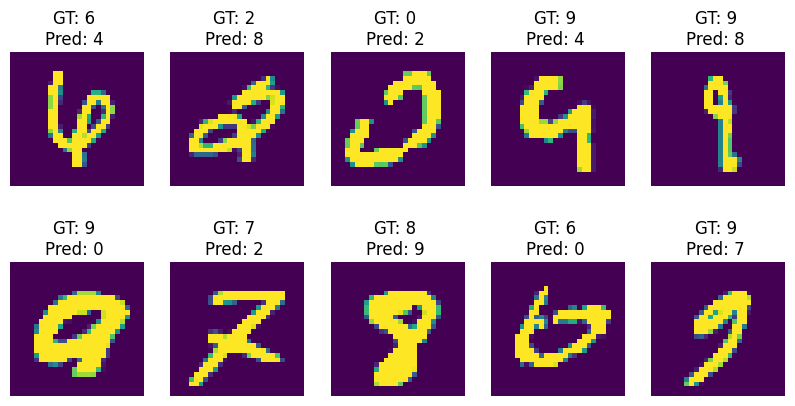

In [ ]:
a= get_misclassified_images_list(model = infer_model_non_dann,
                                  device = device,
                                  test_loader = test_loader,
                                  num_image = 20,
                                  class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plot_misclassified_images(a)

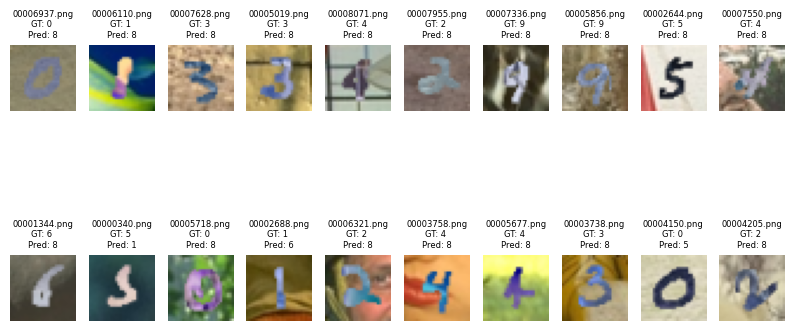

In [ ]:
target_misclassified_images= get_misclassified_images_list(model = infer_model_non_dann,
                                  device = device,
                                  test_loader = dataloader_target_test,
                                  num_image = 20,
                                  class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plot_misclassified_images(target_misclassified_images, num_image = 20)

### Saving the misclassified images

In [ ]:
torch.save(target_misclassified_images, Path(SPECIFIC_MODEL_DIR,'target_misclassified_images.pt'))

In [ ]:
# Load the list of tensors from the file
loaded_misclassified_image_list = torch.load(Path(Path(SPECIFIC_MODEL_DIR,'target_misclassified_images.pt')))

# Verify the loaded tensors
for batch in loaded_misclassified_image_list:
    print(batch[0],batch[1],batch[2])
    break

tensor([[[0.8039, 0.6314, 0.6510,  ..., 0.9569, 0.9843, 0.9922],
         [0.6510, 0.6627, 0.7176,  ..., 0.7294, 0.8667, 0.9412],
         [0.4824, 0.6118, 0.6863,  ..., 0.5020, 0.6157, 0.7608],
         ...,
         [0.6078, 0.5569, 0.6824,  ..., 0.9216, 0.9804, 0.9843],
         [0.5059, 0.5333, 0.6392,  ..., 0.6667, 0.6902, 0.7176],
         [0.4667, 0.4902, 0.5569,  ..., 0.6235, 0.5098, 0.4000]],

        [[0.8510, 0.6824, 0.7216,  ..., 0.9804, 0.9961, 0.9961],
         [0.6784, 0.6824, 0.7608,  ..., 0.8039, 0.9176, 0.9686],
         [0.5176, 0.6392, 0.7294,  ..., 0.5843, 0.6902, 0.8196],
         ...,
         [0.6196, 0.5725, 0.7020,  ..., 0.9569, 0.9922, 0.9961],
         [0.5176, 0.5569, 0.6706,  ..., 0.7020, 0.7098, 0.7333],
         [0.4784, 0.5137, 0.5882,  ..., 0.6627, 0.5451, 0.4392]],

        [[0.8275, 0.6745, 0.7294,  ..., 0.9529, 0.9804, 0.9922],
         [0.6157, 0.6627, 0.7725,  ..., 0.7255, 0.8745, 0.9490],
         [0.4549, 0.6039, 0.7176,  ..., 0.4941, 0.6275, 0.

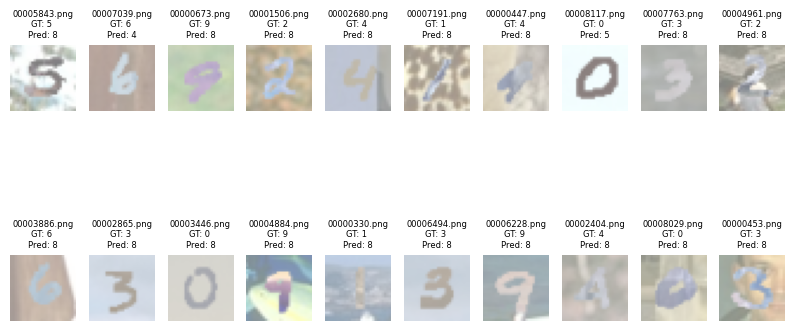

In [ ]:
plot_misclassified_images(loaded_misclassified_image_list, num_image = 20)

In [ ]:
loaded_misclassified_image_list

In [ ]:
for idx, data in enumerate(a):
  print (idx,data[3])

0 00001139.png
1 00002847.png
2 00008441.png
3 00004754.png
4 00003746.png
5 00004250.png
6 00008507.png
7 00007218.png
8 00007493.png
9 00004365.png
10 00001507.png
11 00003029.png
12 00004191.png
13 00005718.png
14 00008274.png
15 00005779.png
16 00008430.png
17 00008709.png
18 00001172.png
19 00008192.png
